# Evaluating Fairness in Machine Learning: Comparative Analysis and Benchmarking of Fairlearn and AIF360 | COMPAS Recidivism Dataset

In [2]:
%load_ext autoreload
%autoreload 2

import os
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from src.constants import RANDOM_STATE, DEFAULT_MODEL_CONFIG, METRICFRAME_METRICS
from src.evaluation import plot_roc, print_confusion_matrix, calculate_fairlearn_metrics, calculate_aif360_metrics

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [3]:
sklearn.set_config(transform_output="pandas")

## Ensure reproducibility

Set random seeds for reproducibility.

In [4]:
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load data

In [5]:
FEATURES = ["sex",
            "age",
            "age_cat",
            "race",
            "juv_fel_count",
            "juv_misd_count",
            "juv_other_count",
            "priors_count",
            "days_b_screening_arrest",
            "c_days_from_compas",
            "c_charge_degree",
            "decile_score.1",
            "score_text",
            "v_type_of_assessment",
            "v_decile_score",
            "v_score_text",
            "end",
            ]
TARGET = "is_recid"
PROTECTED_ATTRIBUTE = "race"

In [6]:
data_raw = pd.read_csv("../data/compas-scores-two-years.csv", usecols=[*FEATURES, TARGET])
data = data_raw.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      7214 non-null   object 
 1   age                      7214 non-null   int64  
 2   age_cat                  7214 non-null   object 
 3   race                     7214 non-null   object 
 4   juv_fel_count            7214 non-null   int64  
 5   juv_misd_count           7214 non-null   int64  
 6   juv_other_count          7214 non-null   int64  
 7   priors_count             7214 non-null   int64  
 8   days_b_screening_arrest  6907 non-null   float64
 9   c_days_from_compas       7192 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  is_recid                 7214 non-null   int64  
 12  decile_score.1           7214 non-null   int64  
 13  score_text               7214 non-null   object 
 14  v_type_of_assessment    

In [8]:
data.isna().sum()

sex                          0
age                          0
age_cat                      0
race                         0
juv_fel_count                0
juv_misd_count               0
juv_other_count              0
priors_count                 0
days_b_screening_arrest    307
c_days_from_compas          22
c_charge_degree              0
is_recid                     0
decile_score.1               0
score_text                   0
v_type_of_assessment         0
v_decile_score               0
v_score_text                 0
end                          0
dtype: int64

In [9]:
data[TARGET].value_counts()

is_recid
0    3743
1    3471
Name: count, dtype: int64

In [10]:
data[PROTECTED_ATTRIBUTE].value_counts()

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

In [11]:
y = data[TARGET]
z = data[PROTECTED_ATTRIBUTE]
X = data.drop(columns=TARGET)

In [12]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [13]:
MODEL_CONFIG = dict(DEFAULT_MODEL_CONFIG, cat_features=X.select_dtypes("object").columns.to_list())

In [14]:
default_model = CatBoostClassifier(**MODEL_CONFIG)
model = default_model.copy()

In [15]:
model.fit(X_train, y_train)

0:	learn: 0.6844627	total: 53.8ms	remaining: 2m 41s
250:	learn: 0.3208956	total: 793ms	remaining: 8.69s
500:	learn: 0.3091280	total: 1.71s	remaining: 8.51s
750:	learn: 0.3038870	total: 2.94s	remaining: 8.8s
1000:	learn: 0.2994238	total: 4.18s	remaining: 8.36s
1250:	learn: 0.2951383	total: 5.34s	remaining: 7.46s
1500:	learn: 0.2916133	total: 6.26s	remaining: 6.25s
1750:	learn: 0.2886633	total: 6.93s	remaining: 4.94s
2000:	learn: 0.2859524	total: 7.59s	remaining: 3.79s
2250:	learn: 0.2837542	total: 8.56s	remaining: 2.85s
2500:	learn: 0.2815680	total: 9.52s	remaining: 1.9s
2750:	learn: 0.2795766	total: 10.7s	remaining: 966ms
2999:	learn: 0.2775952	total: 12s	remaining: 0us


In [16]:
y_pred = pd.Series(model.predict(X_test), name="y_pred", index=y_test.index)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       749
           1       0.84      0.92      0.88       694

    accuracy                           0.88      1443
   macro avg       0.88      0.88      0.88      1443
weighted avg       0.88      0.88      0.88      1443


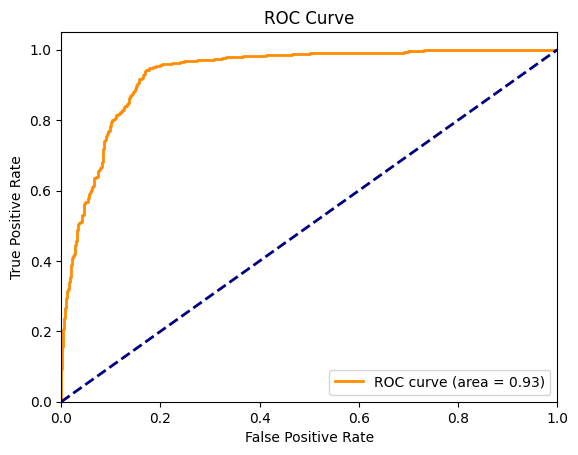

In [18]:
fig, ax = plt.subplots()
plot_roc(model, X_test, y_test, ax)

In [19]:
print_confusion_matrix(model, X_test, y_test)

Confusion Matrix:
[[631 118]
 [ 58 636]]


## Fairness assessment

### Fairlearn

#### Detection

In [20]:
from fairlearn.metrics import MetricFrame

In [21]:
mf = MetricFrame(
    metrics=METRICFRAME_METRICS,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=z_test,
    random_state=RANDOM_STATE,
)

In [22]:
mf.overall

tpr         0.916427
fpr         0.157543
sel         0.522523
count    1443.000000
dtype: float64

In [23]:
mf.by_group

,tpr,fpr,sel,count
race,,,,
African-American,0.919240,0.179739,0.607978,727.0
Asian,0.666667,0.142857,0.300000,10.0
Caucasian,0.914573,0.148649,0.456566,495.0
Hispanic,0.914894,0.137931,0.410448,134.0
Native American,1.000000,0.000000,1.000000,3.0
Other,0.904762,0.113208,0.337838,74.0


In [24]:
calculate_fairlearn_metrics(y_test, y_pred, z_test)

,metric,type,method,value
8,demographic_parity,difference,between_groups,0.700000
10,demographic_parity,difference,to_overall,0.477477
9,demographic_parity,ratio,between_groups,0.300000
11,demographic_parity,ratio,to_overall,0.522523
0,equal_opportunity,difference,between_groups,0.333333
2,equal_opportunity,difference,to_overall,0.249760
1,equal_opportunity,ratio,between_groups,0.666667
3,equal_opportunity,ratio,to_overall,0.727463
4,equalized_odds,difference,between_groups,0.333333
6,equalized_odds,difference,to_overall,0.249760


#### Mitigation

In [37]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

In [38]:
reduction = ExponentiatedGradient(estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10)
reduction.fit(X_train, y_train, sensitive_features=z_train)

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

0:	learn: 0.6844627	total: 4.7ms	remaining: 14.1s
250:	learn: 0.3208956	total: 1.44s	remaining: 15.8s
500:	learn: 0.3091280	total: 2.59s	remaining: 12.9s
750:	learn: 0.3038870	total: 3.71s	remaining: 11.1s
1000:	learn: 0.2994238	total: 4.39s	remaining: 8.76s
1250:	learn: 0.2951383	total: 5.59s	remaining: 7.81s
1500:	learn: 0.2916133	total: 6.78s	remaining: 6.77s
1750:	learn: 0.2886633	total: 8.13s	remaining: 5.8s
2000:	learn: 0.2859524	total: 9.05s	remaining: 4.52s
2250:	learn: 0.2837542	total: 10.2s	remaining: 3.4s
2500:	learn: 0.2815680	total: 10.9s	remaining: 2.18s
2750:	learn: 0.2795766	total: 11.6s	remaining: 1.05s
2999:	learn: 0.2775952	total: 12.3s	remaining: 0us
0:	learn: 0.6844627	total: 17.2ms	remaining: 51.5s
250:	learn: 0.3208956	total: 807ms	remaining: 8.83s
500:	learn: 0.3091280	total: 1.48s	remaining: 7.37s
750:	learn: 0.3038870	total: 2.46s	remaining: 7.37s
1000:	learn: 0.2994238	total: 3.47s	remaining: 6.92s
1250:	learn: 0.2951383	total: 4.4s	remaining: 6.16s
1500:	lea

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x2ae747e20>,
                      estimator=<catboost.core.CatBoostClassifier object at 0x1077f1900>,
                      max_iter=10, nu=0.0020654979885385933)

In [39]:
y_pred_reduced = reduction.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       749
           1       0.83      0.86      0.85       694

    accuracy                           0.85      1443
   macro avg       0.85      0.85      0.85      1443
weighted avg       0.85      0.85      0.85      1443


In [41]:
calculate_fairlearn_metrics(y_test, y_pred, z_test)

,metric,type,method,value
8,demographic_parity,difference,between_groups,0.700000
10,demographic_parity,difference,to_overall,0.477477
9,demographic_parity,ratio,between_groups,0.300000
11,demographic_parity,ratio,to_overall,0.522523
0,equal_opportunity,difference,between_groups,0.333333
2,equal_opportunity,difference,to_overall,0.249760
1,equal_opportunity,ratio,between_groups,0.666667
3,equal_opportunity,ratio,to_overall,0.727463
4,equalized_odds,difference,between_groups,0.333333
6,equalized_odds,difference,to_overall,0.249760


### AIF360

#### Detection

_"Since the main computation of confusion matrices is common for a large set of metrics, we utilize memoization and caching of computations for performance on large-scale datasets."_

In [42]:
priv_group = "Caucasian"

In [43]:
calculate_aif360_metrics(y_test, y_pred, z_test, priv_group=priv_group)

,metric,type,method,value
0,demographic_parity,difference,other,0.100396
1,demographic_parity,ratio,other,1.219895
2,equal_opportunity,difference,other,0.002599


#### Mitigation

In [25]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction as ExponentiatedGradientReductionAif

In [33]:
# drop_prot_attr=True is incompatible with catboost cat_features parameter
reduction_aif = ExponentiatedGradientReductionAif(prot_attr=PROTECTED_ATTRIBUTE, estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10, drop_prot_attr=False)

In [34]:
reduction_aif.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

0:	learn: 0.6844627	total: 15.8ms	remaining: 47.3s
250:	learn: 0.3208956	total: 1.43s	remaining: 15.6s
500:	learn: 0.3091280	total: 2.33s	remaining: 11.6s
750:	learn: 0.3038870	total: 3.15s	remaining: 9.45s
1000:	learn: 0.2994238	total: 4.51s	remaining: 9s
1250:	learn: 0.2951383	total: 5.69s	remaining: 7.95s
1500:	learn: 0.2916133	total: 7.01s	remaining: 7s
1750:	learn: 0.2886633	total: 7.92s	remaining: 5.65s
2000:	learn: 0.2859524	total: 8.6s	remaining: 4.29s
2250:	learn: 0.2837542	total: 9.28s	remaining: 3.09s
2500:	learn: 0.2815680	total: 9.96s	remaining: 1.99s
2750:	learn: 0.2795766	total: 10.6s	remaining: 964ms
2999:	learn: 0.2775952	total: 11.3s	remaining: 0us
0:	learn: 0.6844627	total: 8.18ms	remaining: 24.5s
250:	learn: 0.3208956	total: 812ms	remaining: 8.89s
500:	learn: 0.3091280	total: 1.47s	remaining: 7.34s
750:	learn: 0.3038870	total: 2.13s	remaining: 6.38s
1000:	learn: 0.2994238	total: 2.8s	remaining: 5.59s
1250:	learn: 0.2951383	total: 3.48s	remaining: 4.86s
1500:	learn: 

ExponentiatedGradientReduction(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x2ac10e050>,
                               drop_prot_attr=False,
                               estimator=<catboost.core.CatBoostClassifier object at 0x2ac10e0b0>,
                               max_iter=10, prot_attr='race')

In [35]:
y_pred_reduced_aif = reduction_aif.predict(X_test)

In [44]:
calculate_aif360_metrics(y_test, y_pred_reduced_aif, z_test, priv_group=priv_group)

,metric,type,method,value
0,demographic_parity,difference,other,0.035980
1,demographic_parity,ratio,other,1.075148
2,equal_opportunity,difference,other,-0.097325


In [45]:
print(classification_report(y_test, y_pred_reduced_aif))


              precision    recall  f1-score   support

           0       0.86      0.83      0.85       749
           1       0.82      0.86      0.84       694

    accuracy                           0.84      1443
   macro avg       0.84      0.84      0.84      1443
weighted avg       0.84      0.84      0.84      1443

